In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
# this format of import  -> can't detect tensorboard is alredy installed
import torchvision.transforms as transforms
from torchvision import models

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

import os
from datetime import datetime
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

/opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### if you use the cursor or vs code environment, cmd+shift+p -> python: select interpreter -> select the environment you want to use

# Hyperparameters


In [6]:
args = { 'random_state':42,
        'epochs':50,
        'lr': 2e-3,
        'batch_size': 512,
        'train_path': './train.csv',
        'test_path': './test.csv',
        'train_img_path': './images/train',
        'test_img_path': './images/test',
        'submission_path': './sample_submission.csv'
        }


# Data Check

In [7]:
# load data and create dataframe
train_df, test_df = pd.read_csv(args['train_path']), pd.read_csv(args['test_path'])
train_df.head()

,id,filename,genus
0,8,401ddb5a-ba72-453e-af36-94f67c848408.jpg,Muscicapidae
1,1458,b434e45c-d3f1-42a9-907f-411375222f70.jpg,Anatidae
2,1411,feca4f5f-07c4-4b00-a3cc-748efaa97abf.jpg,Anatidae
3,723,91c2f551-5df8-4808-ba6f-e48714dc9e1d.jpg,Scolopacidae
4,4199,595d31ea-3c6c-4141-9d0a-1dbfbf0b600e.jpg,Strigidae


In [8]:
print(train_df.isnull().sum())

id          0
filename    0
genus       0
dtype: int64


In [9]:
# check the null values and shape
print(f"train set null values: ")
print(train_df.isnull().sum())

print(f"\ntest set null values: ")
print(test_df.isnull().sum())
print(f"\ntrain set shape: {train_df.shape}, test set shape: {test_df.shape}")

train set null values: 
id          0
filename    0
genus       0
dtype: int64

test set null values: 
id          0
filename    0
dtype: int64

train set shape: (4258, 3), test set shape: (540, 2)


# Data EDA

number of target classes: 27


<Axes: xlabel='count', ylabel='genus'>

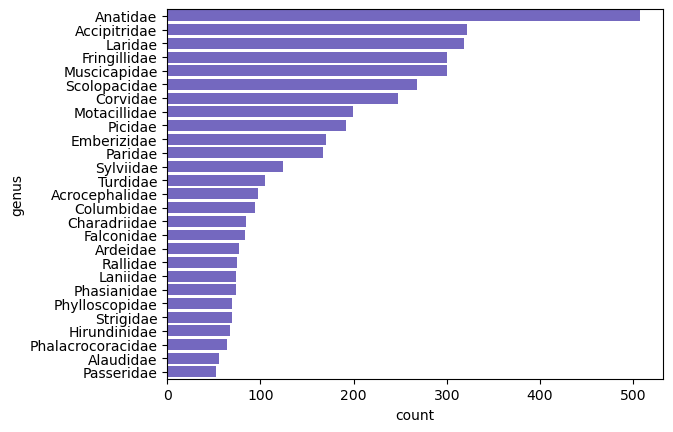

In [10]:
# check the number of classes
# data is imbalanced
# Let's see if the imbalance is critical by using confusion matrix
print(f"number of target classes: {train_df['genus'].nunique()}")
sns.countplot(train_df['genus'], order=train_df.genus.value_counts().sort_values(ascending=False).index, color='slateblue')


train set image shape: (300, 300, 3)    4258
Name: count, dtype: int64


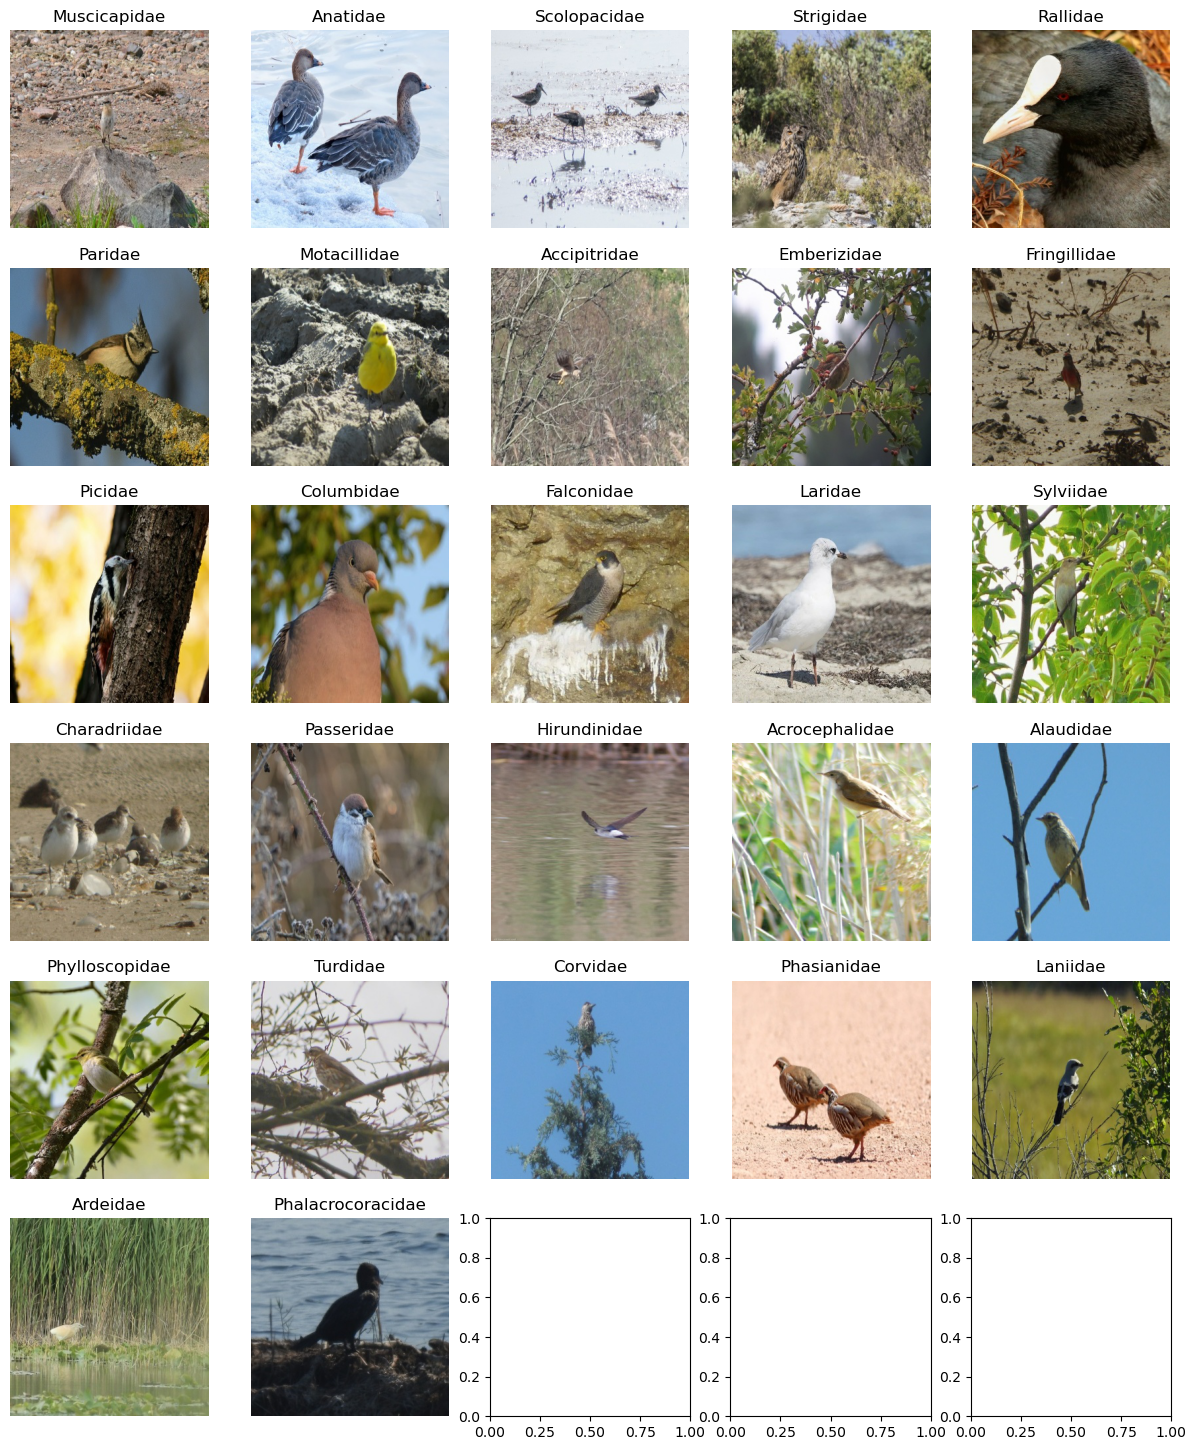

In [11]:
# check the shape of the train set image
# all images are 300 * 300 * 3(RGB)
# observation: 
# 1. some target is placed in the middle or corner of the plot -> Center or Five Crop Augmentation
# 2. some target is very small -> Five Crop Augmentation
# 3. some targets are in a picture.
# 4. some targets are hide in the background
# 5. most pose of the targets are standing -> do not need the rotation augmentation
# + random perspective augmentation

n_classes = train_df['genus'].nunique()
n_cols = 5
n_rows = (n_classes + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 18))
img_size_list , classes_list = [], []

for step in range(len(train_df)):
    img_name = train_df['filename'][step]
    img_path = os.path.join(args['train_img_path'], img_name)
    img = mpimg.imread(img_path)
    if not train_df['genus'][step] in classes_list:
        classes_list.append(train_df['genus'][step])
        row, col = (len(classes_list)-1)//n_cols, (len(classes_list)-1)%n_cols
        ax[row][col].imshow(img)
        ax[row][col].set_title(train_df['genus'][step])
        ax[row][col].axis('off')    
        
    img_size_list.append(img.shape)

print(f"train set image shape: {pd.Series(img_size_list).value_counts()}")

In [12]:
# check the shape of the test set image
for step in range(len(test_df)):
    img_name = test_df['filename'][step]
    img_path = os.path.join(args['test_img_path'], img_name)
    img = mpimg.imread(img_path)
    img_size_list.append(img.shape)

print(f"test set image shape: {pd.Series(img_size_list).value_counts()}")

test set image shape: (300, 300, 3)    4798
Name: count, dtype: int64


# Preprocessing

## target encoding

In [13]:
class Encoder():
    def __init__(self):
        self.label_encoder = LabelEncoder()
    
    # only for train set
    def fit_transform(self, label: pd.Series):
        return self.label_encoder.fit_transform(label)
    
    # for validation or test set
    def transform(self, label: pd.Series):
        # update label encoder classes for new labels
        for unique_label in label.unique():
            if unique_label not in self.label_encoder.classes_:
                self.label_encoder.classes_.append(unique_label)
        
        return self.label_encoder.transform(label)
    
    def inverse_transform(self, label: pd.Series):
        return self.label_encoder.inverse_transform(label)

## Custom Dataset
### problem!! -> tranform을 val 경우를 나누지 않았다!!!

In [14]:
base_transform = {
    'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    ]),
    'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    ])
}

In [15]:
# custom augmentation
# original image size is 300 * 300 * 3
custom_data_transform = {
    'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(150),
    transforms.Resize((64, 64)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    
    # dataset of ImageNet mean, std
    transforms.Normalize(mean=[0.485, 0.456, 0.406]
                         , std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    # dataset of ImageNet mean, std
    transforms.Normalize(mean=[0.485, 0.456, 0.406]
                         , std=[0.229, 0.224, 0.225])
    ])
}

In [16]:
# ImageNet Augmentation
imgnet_data_transform = {
    'train': transforms.Compose([
        # toTensor
        transforms.ToTensor(),
        # 64*64 로 transform
        transforms.Resize((64, 64)),
        # flip, rotation, crop
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop(size=64),
        
        # normalize [means of RGB], [std of RGB] <- imageNet에서 온 값 :
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])

    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.CenterCrop(size=64),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [17]:
class CustomDataset(Dataset):
    def __init__(self, df, img_path, transform=None, flag='train'):
        self.df = df
        self.img_path = img_path
        self.transform = transform
        self.flag = flag
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df['id'][idx]
        img_name = self.df['filename'][idx]
        img_path = os.path.join(self.img_path, img_name)
        # get label
        if self.flag == 'train':
            label = torch.tensor(self.df['genus'][idx], dtype=torch.long)
        
        # read image
        image = mpimg.imread(img_path)
        # transform
        if self.transform:
            image = self.transform(image)
            
        if self.flag == 'train':
            return (image, label)
        else:
            return (image, )


In [43]:
def preprocess_data(train_df, test_df, args, transform):
    # encoding target
    target_encoder = Encoder()
    train_df['genus'] = target_encoder.fit_transform(train_df['genus'])
    print(f"target classes: {target_encoder.label_encoder.classes_}")
    
    # split train set into train and validation set and reset index
    train_df, validation_df = train_test_split(train_df, test_size=.2, random_state=args['random_state'], shuffle=True, stratify=train_df['genus'])
    train_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)
    
    train_set = CustomDataset(train_df, args['train_img_path'], transform=transform['train'], flag='train')
    validation_set = CustomDataset(validation_df, args['train_img_path'], transform=transform['test'], flag='train')
    test_set = CustomDataset(test_df, args['test_img_path'], transform=transform['test'], flag='test')
    print(f"train set length: {len(train_set)}, test set length: {len(test_set)}")
    print(f"train set image shape: {train_set[0][0].shape}, train set label: {train_set[0][1]}, test set image shape: {test_set[0][0].shape}")
    
    len(train_set), len(validation_set), len(test_set)
    
    train_loader = DataLoader(train_set, batch_size=args['batch_size'], shuffle=True)
    validation_loader = DataLoader(validation_set, batch_size=len(validation_set), shuffle=True)
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
    
    return train_loader, validation_loader, test_loader

# device setting


In [19]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


# Training and Evaluation

In [20]:

def train(model, train_loader, criterion, optimizer, writer, epoch):
    model.train()
    model.zero_grad()
    
    train_loss = 0
    corrects = 0
    # training
    for images, labels in tqdm(train_loader):
        # zero grad
        optimizer.zero_grad()
        
        # move to device
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        outputs_idx = torch.argmax(outputs, dim=1)
        
        # calculate epoch loss and accuracy
        train_loss += loss.item()
        corrects += (outputs_idx == labels).sum().item()
        
        # backward pass and update weights
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    train_acc = corrects / len(train_loader.dataset)
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Acc/Train', train_acc, epoch)
    writer.add_scalar('lr/Train', optimizer.param_groups[0]['lr'], epoch)
    print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

In [21]:

def evaluate(model, validation_loader, criterion, writer, epoch):
    model.eval()
    
    with torch.no_grad():
        val_loss = 0
        corrects = 0
        f1_scores = 0
        for images, labels in tqdm(validation_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            outputs_idx = torch.argmax(outputs, dim=1)
            corrects += (outputs_idx == labels).sum().item()
            f1_scores += f1_score(outputs_idx.cpu(), labels.cpu(), average='macro')
        val_loss /= len(validation_loader)
        val_acc = corrects / len(validation_loader.dataset)
        val_f1 = f1_scores / len(validation_loader)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Acc/Validation', val_acc, epoch)
        writer.add_scalar('F1/Validation', val_f1, epoch)
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}")
        return val_acc


In [22]:
def fitting(model, train_loader, validation_loader, criterion, optimizer, scheduler, writer, num_epochs, current_time):
    best_score = 0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train(model, train_loader, criterion, optimizer, writer, epoch)
        scheduler.step()
        
        eval_score = evaluate(model, validation_loader, criterion, writer, epoch)
        if eval_score > best_score:
            best_score = eval_score
            print(f"Best score updated: {best_score:.4f}\n")
            torch.save(model.state_dict(), f"./checkpoints/pre-trained_{current_time}_total_aug.pth")

# Model definition

## Custom Model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_dim, 16, kernel_size=3, stride=1, padding=1), # 64*64*3 -> 64*64*16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64*16 -> 32*32*16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 32*32*16 -> 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32*32 -> 16*16*32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 16*16*32 -> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16*16*64 -> 8*8*64
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(8*8*64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x


In [24]:
# check the impact of the augmentation
data_transforms = {
    'base': base_transform,
    'custom': custom_data_transform,
    'imgnet': imgnet_data_transform
}

In [41]:
for name, transform in data_transforms.items():
    train_df, test_df = pd.read_csv(args['train_path']), pd.read_csv(args['test_path'])
    train_loader, validation_loader, test_loader = preprocess_data(train_df, test_df, args, transform)
    
    current_time = datetime.now().strftime("%y%m%d-%H%M%S")
    log_dir_custom = f"./logs/customModel_{current_time}_{name}"

    # SummaryWriter for pre-trained model
    writer_custom = SummaryWriter(log_dir=log_dir_custom)
    print(f"{name} set is ready")
    
    custom_model = CustomModel(input_dim=3, output_dim=n_classes).to(device)
    optimizer = optim.Adam(custom_model.parameters(), lr=args['lr'])
    scheduler = CosineAnnealingLR(optimizer, T_max=args['epochs'], eta_min=args['lr']/1000)
    loss_fn = nn.CrossEntropyLoss()
    
    fitting(custom_model, train_loader, validation_loader, loss_fn, optimizer, scheduler, writer_custom, args['epochs'], current_time)
    
    # Write graph of baseline
    sample_input, _ = next(iter(train_loader))
    sample_input = sample_input.to(device)
    writer_custom.add_graph(custom_model, sample_input)
    writer_custom.close()

target classes: ['Accipitridae' 'Acrocephalidae' 'Alaudidae' 'Anatidae' 'Ardeidae'
 'Charadriidae' 'Columbidae' 'Corvidae' 'Emberizidae' 'Falconidae'
 'Fringillidae' 'Hirundinidae' 'Laniidae' 'Laridae' 'Motacillidae'
 'Muscicapidae' 'Paridae' 'Passeridae' 'Phalacrocoracidae' 'Phasianidae'
 'Phylloscopidae' 'Picidae' 'Rallidae' 'Scolopacidae' 'Strigidae'
 'Sylviidae' 'Turdidae']
train set length: 3406, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 7, test set image shape: torch.Size([3, 64, 64])
base set is ready
Epoch 1/10


100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


 Train Loss: 2.8849, Train Acc: 0.1903


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Validation Loss: 3.4927, Validation Acc: 0.1127, Validation F1: 0.0234
Best score updated: 0.1127

Epoch 2/10


100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


 Train Loss: 2.4097, Train Acc: 0.3042


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Validation Loss: 3.4227, Validation Acc: 0.1749, Validation F1: 0.0464
Best score updated: 0.1749

Epoch 3/10


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


 Train Loss: 1.9269, Train Acc: 0.4706


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Validation Loss: 3.3382, Validation Acc: 0.1608, Validation F1: 0.0469
Epoch 4/10


100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


 Train Loss: 1.2933, Train Acc: 0.7223


100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Validation Loss: 3.0074, Validation Acc: 0.1843, Validation F1: 0.0819
Best score updated: 0.1843

Epoch 5/10


100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


 Train Loss: 0.7145, Train Acc: 0.8987


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Validation Loss: 2.9086, Validation Acc: 0.2195, Validation F1: 0.1064
Best score updated: 0.2195

Epoch 6/10


100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


 Train Loss: 0.3754, Train Acc: 0.9624


100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Validation Loss: 3.0370, Validation Acc: 0.2101, Validation F1: 0.0881
Epoch 7/10


100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


 Train Loss: 0.2175, Train Acc: 0.9841


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Validation Loss: 2.9336, Validation Acc: 0.2019, Validation F1: 0.0994
Epoch 8/10


100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


 Train Loss: 0.1493, Train Acc: 0.9897


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Validation Loss: 2.9751, Validation Acc: 0.2136, Validation F1: 0.1037
Epoch 9/10


100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


 Train Loss: 0.1219, Train Acc: 0.9950


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Validation Loss: 2.9972, Validation Acc: 0.2148, Validation F1: 0.1032
Epoch 10/10


100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


 Train Loss: 0.1098, Train Acc: 0.9950


100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Validation Loss: 2.9890, Validation Acc: 0.2160, Validation F1: 0.1048
target classes: ['Accipitridae' 'Acrocephalidae' 'Alaudidae' 'Anatidae' 'Ardeidae'
 'Charadriidae' 'Columbidae' 'Corvidae' 'Emberizidae' 'Falconidae'
 'Fringillidae' 'Hirundinidae' 'Laniidae' 'Laridae' 'Motacillidae'
 'Muscicapidae' 'Paridae' 'Passeridae' 'Phalacrocoracidae' 'Phasianidae'
 'Phylloscopidae' 'Picidae' 'Rallidae' 'Scolopacidae' 'Strigidae'
 'Sylviidae' 'Turdidae']
train set length: 3406, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 7, test set image shape: torch.Size([3, 64, 64])
custom set is ready
Epoch 1/10


100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


 Train Loss: 3.0320, Train Acc: 0.1433


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


Validation Loss: 3.0155, Validation Acc: 0.1608, Validation F1: 0.0459
Best score updated: 0.1608

Epoch 2/10


100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


 Train Loss: 2.8496, Train Acc: 0.1820


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Validation Loss: 2.8654, Validation Acc: 0.1808, Validation F1: 0.0566
Best score updated: 0.1808

Epoch 3/10


100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


 Train Loss: 2.7751, Train Acc: 0.1926


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Validation Loss: 2.8437, Validation Acc: 0.1819, Validation F1: 0.0570
Best score updated: 0.1819

Epoch 4/10


100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


 Train Loss: 2.7267, Train Acc: 0.2005


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Validation Loss: 2.8729, Validation Acc: 0.1631, Validation F1: 0.0720
Epoch 5/10


100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


 Train Loss: 2.7043, Train Acc: 0.2208


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Validation Loss: 2.8596, Validation Acc: 0.1784, Validation F1: 0.0664
Epoch 6/10


100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


 Train Loss: 2.6556, Train Acc: 0.2272


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Validation Loss: 2.7246, Validation Acc: 0.2183, Validation F1: 0.1017
Best score updated: 0.2183

Epoch 7/10


100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


 Train Loss: 2.6179, Train Acc: 0.2346


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Validation Loss: 2.7200, Validation Acc: 0.2171, Validation F1: 0.0844
Epoch 8/10


100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


 Train Loss: 2.5967, Train Acc: 0.2457


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Validation Loss: 2.6864, Validation Acc: 0.2230, Validation F1: 0.0931
Best score updated: 0.2230

Epoch 9/10


100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


 Train Loss: 2.5803, Train Acc: 0.2540


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Validation Loss: 2.6802, Validation Acc: 0.2207, Validation F1: 0.0955
Epoch 10/10


100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


 Train Loss: 2.5625, Train Acc: 0.2507


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Validation Loss: 2.6759, Validation Acc: 0.2183, Validation F1: 0.0932
target classes: ['Accipitridae' 'Acrocephalidae' 'Alaudidae' 'Anatidae' 'Ardeidae'
 'Charadriidae' 'Columbidae' 'Corvidae' 'Emberizidae' 'Falconidae'
 'Fringillidae' 'Hirundinidae' 'Laniidae' 'Laridae' 'Motacillidae'
 'Muscicapidae' 'Paridae' 'Passeridae' 'Phalacrocoracidae' 'Phasianidae'
 'Phylloscopidae' 'Picidae' 'Rallidae' 'Scolopacidae' 'Strigidae'
 'Sylviidae' 'Turdidae']
train set length: 3406, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 7, test set image shape: torch.Size([3, 64, 64])
imgnet set is ready
Epoch 1/10


100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


 Train Loss: 2.9490, Train Acc: 0.1703


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Validation Loss: 2.8805, Validation Acc: 0.1925, Validation F1: 0.0593
Best score updated: 0.1925

Epoch 2/10


100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


 Train Loss: 2.7225, Train Acc: 0.2196


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Validation Loss: 2.7635, Validation Acc: 0.2077, Validation F1: 0.0749
Best score updated: 0.2077

Epoch 3/10


100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


 Train Loss: 2.6046, Train Acc: 0.2463


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Validation Loss: 2.7180, Validation Acc: 0.2300, Validation F1: 0.0810
Best score updated: 0.2300

Epoch 4/10


100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


 Train Loss: 2.5012, Train Acc: 0.2710


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Validation Loss: 2.6738, Validation Acc: 0.2406, Validation F1: 0.1166
Best score updated: 0.2406

Epoch 5/10


100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


 Train Loss: 2.4273, Train Acc: 0.2910


100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Validation Loss: 2.6472, Validation Acc: 0.2312, Validation F1: 0.1047
Epoch 6/10


100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


 Train Loss: 2.3373, Train Acc: 0.3124


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Validation Loss: 2.6325, Validation Acc: 0.2441, Validation F1: 0.0992
Best score updated: 0.2441

Epoch 7/10


100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


 Train Loss: 2.2342, Train Acc: 0.3435


100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Validation Loss: 2.5764, Validation Acc: 0.2617, Validation F1: 0.1216
Best score updated: 0.2617

Epoch 8/10


100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


 Train Loss: 2.1878, Train Acc: 0.3485


100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Validation Loss: 2.5679, Validation Acc: 0.2617, Validation F1: 0.1243
Epoch 9/10


100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


 Train Loss: 2.1376, Train Acc: 0.3767


100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Validation Loss: 2.5401, Validation Acc: 0.2570, Validation F1: 0.1295
Epoch 10/10


100%|██████████| 27/27 [00:09<00:00,  2.77it/s]


 Train Loss: 2.1063, Train Acc: 0.3893


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Validation Loss: 2.5348, Validation Acc: 0.2700, Validation F1: 0.1307
Best score updated: 0.2700



## Pre-trained model
- VGG16 : 
- ResNet50: 

In [25]:
# 1. 모델 구조 확인
model = models.resnet34(pretrained=True)

# 모델의 전체 구조 출력
print("전체 모델 구조:")
print(model)

# 각 레이어의 이름과 파라미터 출력
print("\n각 레이어 세부 정보:")
for name, param in model.named_parameters():
    print(f"Layer: {name}, Size: {param.size()}")

# 2. 레이어 freeze 예시
def freeze_layers(model, num_layers_to_freeze):
    # conv1과 bn1은 항상 처음에 있는 레이어
    layers_to_freeze = []
    
    # layer1, layer2, layer3, layer4 선택적으로 freeze
    if num_layers_to_freeze > 0:
        layers_to_freeze.append(model.conv1)
        layers_to_freeze.append(model.bn1)
    if num_layers_to_freeze >= 1:
        layers_to_freeze.append(model.layer1)
    if num_layers_to_freeze >= 2:
        layers_to_freeze.append(model.layer2)
    if num_layers_to_freeze >= 3:
        layers_to_freeze.append(model.layer3)
    if num_layers_to_freeze >= 4:
        layers_to_freeze.append(model.layer4)
    
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False

    return model

# 예시: 처음 2개의 레이어 블록을 freeze
model = freeze_layers(model, num_layers_to_freeze=2)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, n_classes),
    nn.BatchNorm1d(n_classes),
    nn.ReLU(),
    nn.LogSoftmax(dim=1)
)


# freeze된 상태 확인
print("\nFreeze 상태 확인:")
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires_grad: {param.requires_grad}")

전체 모델 구조:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

In [26]:
data_transforms.pop('base')

{'train': Compose(
     ToTensor()
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
 ),
 'test': Compose(
     ToTensor()
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
 )}

In [27]:
data_transforms

{'custom': {'train': Compose(
      ToTensor()
      RandomCrop(size=(150, 150), padding=None)
      Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
      RandomPerspective(p=0.5)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ),
  'test': Compose(
      ToTensor()
      Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )},
 'imgnet': {'train': Compose(
      ToTensor()
      Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
      RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
      RandomCrop(size=(64, 64), padding=None)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ),
  'test': Compose(
      ToTensor()
      Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias

In [51]:
for name, transform in data_transforms.items():
    train_df, test_df = pd.read_csv(args['train_path']), pd.read_csv(args['test_path'])
    train_loader, validation_loader, test_loader = preprocess_data(train_df, test_df, args, transform)
    num_freeze = 2
    current_time = datetime.now().strftime("%y%m%d-%H%M%S")
    log_dir_pretrained = f"./logs/pre-trained_{current_time}_{name}_freeze_{num_freeze}"

    # SummaryWriter for pre-trained model
    writer_pretrained = SummaryWriter(log_dir=log_dir_pretrained)
    print(f"{name} set is ready")
    
    # reference: https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet34.html#torchvision.models.resnet34
    resnet34 = models.resnet34(pretrained=True)
    # https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L167
    # line206 보면, __init__에서 fc라고 이미 정의를 해둠.
    model_hyperparameters = {
        'input_dim': resnet34.fc.in_features,
        'output_dim': train_df['genus'].nunique()
    }
    resnet34.fc = nn.Sequential(
        nn.Linear(resnet34.fc.in_features, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, n_classes),
        nn.LogSoftmax(dim=1)
    )
    resnet34.to(device)
    # 처음 0개의 레이어 블록을 freeze
    resnet34 = freeze_layers(resnet34, num_layers_to_freeze=num_freeze)
    
    optimizer = optim.Adam(resnet34.parameters(), lr=args['lr'])
    scheduler = CosineAnnealingLR(optimizer, T_max=args['epochs'], eta_min=args['lr']/1000)
    loss_fn = nn.CrossEntropyLoss()     
    
    fitting(resnet34, train_loader, validation_loader, loss_fn, optimizer, scheduler, writer_pretrained, args['epochs'], current_time)
    
    # Write graph of baseline
    sample_input, _ = next(iter(train_loader))
    sample_input = sample_input.to(device)
    writer_pretrained.add_graph(resnet34, sample_input)
    writer_pretrained.close()

target classes: ['Accipitridae' 'Acrocephalidae' 'Alaudidae' 'Anatidae' 'Ardeidae'
 'Charadriidae' 'Columbidae' 'Corvidae' 'Emberizidae' 'Falconidae'
 'Fringillidae' 'Hirundinidae' 'Laniidae' 'Laridae' 'Motacillidae'
 'Muscicapidae' 'Paridae' 'Passeridae' 'Phalacrocoracidae' 'Phasianidae'
 'Phylloscopidae' 'Picidae' 'Rallidae' 'Scolopacidae' 'Strigidae'
 'Sylviidae' 'Turdidae']
train set length: 3406, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 7, test set image shape: torch.Size([3, 64, 64])
custom set is ready
Epoch 1/20


100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


 Train Loss: 3.0754, Train Acc: 0.1574


100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Validation Loss: 3.2694, Validation Acc: 0.2195, Validation F1: 0.0693
Best score updated: 0.2195

Epoch 2/20


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


 Train Loss: 2.7116, Train Acc: 0.2722


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


Validation Loss: 2.8454, Validation Acc: 0.2500, Validation F1: 0.0755
Best score updated: 0.2500

Epoch 3/20


100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


 Train Loss: 2.5476, Train Acc: 0.3218


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Validation Loss: 2.7903, Validation Acc: 0.2606, Validation F1: 0.0936
Best score updated: 0.2606

Epoch 4/20


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


 Train Loss: 2.4056, Train Acc: 0.3511


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Validation Loss: 2.6284, Validation Acc: 0.2700, Validation F1: 0.1093
Best score updated: 0.2700

Epoch 5/20


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


 Train Loss: 2.3132, Train Acc: 0.3776


100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


Validation Loss: 2.5904, Validation Acc: 0.2840, Validation F1: 0.1258
Best score updated: 0.2840

Epoch 6/20


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


 Train Loss: 2.2244, Train Acc: 0.3890


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Validation Loss: 2.5712, Validation Acc: 0.2946, Validation F1: 0.1356
Best score updated: 0.2946

Epoch 7/20


100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


 Train Loss: 2.1501, Train Acc: 0.4099


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Validation Loss: 2.5025, Validation Acc: 0.3122, Validation F1: 0.1469
Best score updated: 0.3122

Epoch 8/20


100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


 Train Loss: 2.0693, Train Acc: 0.4275


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Validation Loss: 2.4605, Validation Acc: 0.3134, Validation F1: 0.1500
Best score updated: 0.3134

Epoch 9/20


100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


 Train Loss: 1.9989, Train Acc: 0.4451


100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


Validation Loss: 2.4177, Validation Acc: 0.3392, Validation F1: 0.1727
Best score updated: 0.3392

Epoch 10/20


100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


 Train Loss: 1.9517, Train Acc: 0.4715


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Validation Loss: 2.4277, Validation Acc: 0.3298, Validation F1: 0.1624
Epoch 11/20


100%|██████████| 7/7 [00:14<00:00,  2.05s/it]


 Train Loss: 1.8697, Train Acc: 0.4862


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


Validation Loss: 2.4474, Validation Acc: 0.3028, Validation F1: 0.1594
Epoch 12/20


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


 Train Loss: 1.8259, Train Acc: 0.4968


100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


Validation Loss: 2.4351, Validation Acc: 0.3228, Validation F1: 0.1743
Epoch 13/20


100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


 Train Loss: 1.7592, Train Acc: 0.5185


100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


Validation Loss: 2.3980, Validation Acc: 0.3263, Validation F1: 0.1783
Epoch 14/20


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


 Train Loss: 1.6916, Train Acc: 0.5355


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Validation Loss: 2.3626, Validation Acc: 0.3462, Validation F1: 0.2046
Best score updated: 0.3462

Epoch 15/20


100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


 Train Loss: 1.6545, Train Acc: 0.5531


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


Validation Loss: 2.3816, Validation Acc: 0.3451, Validation F1: 0.1839
Epoch 16/20


100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


 Train Loss: 1.6312, Train Acc: 0.5587


100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Validation Loss: 2.3719, Validation Acc: 0.3404, Validation F1: 0.1930
Epoch 17/20


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


 Train Loss: 1.5895, Train Acc: 0.5702


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Validation Loss: 2.3747, Validation Acc: 0.3509, Validation F1: 0.2043
Best score updated: 0.3509

Epoch 18/20


100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


 Train Loss: 1.5541, Train Acc: 0.5825


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


Validation Loss: 2.3864, Validation Acc: 0.3439, Validation F1: 0.1985
Epoch 19/20


100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


 Train Loss: 1.5246, Train Acc: 0.6069


100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


Validation Loss: 2.3853, Validation Acc: 0.3415, Validation F1: 0.1949
Epoch 20/20


100%|██████████| 7/7 [00:21<00:00,  3.08s/it]


 Train Loss: 1.5045, Train Acc: 0.6051


100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


Validation Loss: 2.3846, Validation Acc: 0.3415, Validation F1: 0.1942
target classes: ['Accipitridae' 'Acrocephalidae' 'Alaudidae' 'Anatidae' 'Ardeidae'
 'Charadriidae' 'Columbidae' 'Corvidae' 'Emberizidae' 'Falconidae'
 'Fringillidae' 'Hirundinidae' 'Laniidae' 'Laridae' 'Motacillidae'
 'Muscicapidae' 'Paridae' 'Passeridae' 'Phalacrocoracidae' 'Phasianidae'
 'Phylloscopidae' 'Picidae' 'Rallidae' 'Scolopacidae' 'Strigidae'
 'Sylviidae' 'Turdidae']
train set length: 3406, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 7, test set image shape: torch.Size([3, 64, 64])
imgnet set is ready
Epoch 1/20


100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


 Train Loss: 3.0346, Train Acc: 0.1706


100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


Validation Loss: 4.1276, Validation Acc: 0.2066, Validation F1: 0.0505
Best score updated: 0.2066

Epoch 2/20


100%|██████████| 7/7 [00:20<00:00,  2.92s/it]


 Train Loss: 2.6194, Train Acc: 0.3068


100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


Validation Loss: 3.2656, Validation Acc: 0.2383, Validation F1: 0.0782
Best score updated: 0.2383

Epoch 3/20


100%|██████████| 7/7 [00:19<00:00,  2.74s/it]


 Train Loss: 2.4126, Train Acc: 0.3555


100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


Validation Loss: 2.5609, Validation Acc: 0.3192, Validation F1: 0.1470
Best score updated: 0.3192

Epoch 4/20


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


 Train Loss: 2.2602, Train Acc: 0.3981


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Validation Loss: 2.5337, Validation Acc: 0.3122, Validation F1: 0.1481
Epoch 5/20


100%|██████████| 7/7 [00:22<00:00,  3.24s/it]


 Train Loss: 2.1098, Train Acc: 0.4366


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


Validation Loss: 2.5360, Validation Acc: 0.3216, Validation F1: 0.1526
Best score updated: 0.3216

Epoch 6/20


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


 Train Loss: 1.9840, Train Acc: 0.4662


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Validation Loss: 2.5119, Validation Acc: 0.3169, Validation F1: 0.1586
Epoch 7/20


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


 Train Loss: 1.8676, Train Acc: 0.5132


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Validation Loss: 2.4227, Validation Acc: 0.3357, Validation F1: 0.1720
Best score updated: 0.3357

Epoch 8/20


100%|██████████| 7/7 [00:14<00:00,  2.11s/it]


 Train Loss: 1.7508, Train Acc: 0.5355


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Validation Loss: 2.3869, Validation Acc: 0.3380, Validation F1: 0.1834
Best score updated: 0.3380

Epoch 9/20


100%|██████████| 7/7 [00:26<00:00,  3.73s/it]


 Train Loss: 1.6364, Train Acc: 0.5702


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Validation Loss: 2.4160, Validation Acc: 0.3427, Validation F1: 0.1812
Best score updated: 0.3427

Epoch 10/20


100%|██████████| 7/7 [00:24<00:00,  3.44s/it]


 Train Loss: 1.4999, Train Acc: 0.6139


100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


Validation Loss: 2.4052, Validation Acc: 0.3474, Validation F1: 0.1995
Best score updated: 0.3474

Epoch 11/20


 57%|█████▋    | 4/7 [00:27<00:20,  6.92s/it]


KeyboardInterrupt: 

In [28]:
# best model
train_df, test_df = pd.read_csv(args['train_path']), pd.read_csv(args['test_path'])
train_loader, validation_loader, test_loader = preprocess_data(train_df, test_df, args, custom_data_transform)
num_freeze = 2
current_time = datetime.now().strftime("%y%m%d-%H%M%S")
log_dir_pretrained = f"./logs/pre-trained_{current_time}_custom_freeze_{num_freeze}"

# SummaryWriter for pre-trained model
writer_pretrained = SummaryWriter(log_dir=log_dir_pretrained)
print(f"custom set is ready")
    
# reference: https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet34.html#torchvision.models.resnet34
resnet34 = models.resnet34(pretrained=True)
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L167
# line206 보면, __init__에서 fc라고 이미 정의를 해둠.
model_hyperparameters = {
    'input_dim': resnet34.fc.in_features,
    'output_dim': train_df['genus'].nunique()
}
resnet34.fc = nn.Linear(resnet34.fc.in_features, n_classes)
resnet34.to(device)
# 처음 0개의 레이어 블록을 freeze
resnet34 = freeze_layers(resnet34, num_layers_to_freeze=num_freeze)
    
optimizer = optim.Adam(resnet34.parameters(), lr=args['lr'])
scheduler = CosineAnnealingLR(optimizer, T_max=4, eta_min=args['lr']/1000)
loss_fn = nn.CrossEntropyLoss()     
    
fitting(resnet34, train_loader, validation_loader, loss_fn, optimizer, scheduler, writer_pretrained, 100, current_time)
    
# Write graph of baseline
sample_input, _ = next(iter(train_loader))
sample_input = sample_input.to(device)
writer_pretrained.add_graph(resnet34, sample_input)
writer_pretrained.close()

target classes: ['Accipitridae' 'Acrocephalidae' 'Alaudidae' 'Anatidae' 'Ardeidae'
 'Charadriidae' 'Columbidae' 'Corvidae' 'Emberizidae' 'Falconidae'
 'Fringillidae' 'Hirundinidae' 'Laniidae' 'Laridae' 'Motacillidae'
 'Muscicapidae' 'Paridae' 'Passeridae' 'Phalacrocoracidae' 'Phasianidae'
 'Phylloscopidae' 'Picidae' 'Rallidae' 'Scolopacidae' 'Strigidae'
 'Sylviidae' 'Turdidae']
train set length: 3406, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 7, test set image shape: torch.Size([3, 64, 64])
custom set is ready
Epoch 1/100


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


 Train Loss: 3.2606, Train Acc: 0.1421


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Validation Loss: 142.7649, Validation Acc: 0.0681, Validation F1: 0.0095
Best score updated: 0.0681

Epoch 2/100


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


 Train Loss: 2.7632, Train Acc: 0.2311


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Validation Loss: 69.8393, Validation Acc: 0.0845, Validation F1: 0.0127
Best score updated: 0.0845

Epoch 3/100


100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


 Train Loss: 2.5546, Train Acc: 0.2689


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Validation Loss: 3.6366, Validation Acc: 0.2300, Validation F1: 0.0890
Best score updated: 0.2300

Epoch 4/100


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


 Train Loss: 2.4368, Train Acc: 0.2883


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Validation Loss: 2.6284, Validation Acc: 0.2700, Validation F1: 0.1238
Best score updated: 0.2700

Epoch 5/100


100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


 Train Loss: 2.4057, Train Acc: 0.2951


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Validation Loss: 2.5262, Validation Acc: 0.2688, Validation F1: 0.1156
Epoch 6/100


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


 Train Loss: 2.3889, Train Acc: 0.3074


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Validation Loss: 2.4716, Validation Acc: 0.2829, Validation F1: 0.1206
Best score updated: 0.2829

Epoch 7/100


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


 Train Loss: 2.3254, Train Acc: 0.3385


100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Validation Loss: 2.4858, Validation Acc: 0.2864, Validation F1: 0.1196
Best score updated: 0.2864

Epoch 8/100


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


 Train Loss: 2.2882, Train Acc: 0.3312


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Validation Loss: 2.5050, Validation Acc: 0.2981, Validation F1: 0.1395
Best score updated: 0.2981

Epoch 9/100


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


 Train Loss: 2.2046, Train Acc: 0.3550


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Validation Loss: 2.5267, Validation Acc: 0.2876, Validation F1: 0.1448
Epoch 10/100


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


 Train Loss: 2.0851, Train Acc: 0.3855


100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


Validation Loss: 2.5019, Validation Acc: 0.3052, Validation F1: 0.1634
Best score updated: 0.3052

Epoch 11/100


100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


 Train Loss: 2.0158, Train Acc: 0.4090


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Validation Loss: 2.3869, Validation Acc: 0.3310, Validation F1: 0.1738
Best score updated: 0.3310

Epoch 12/100


100%|██████████| 7/7 [00:38<00:00,  5.56s/it]


 Train Loss: 1.8769, Train Acc: 0.4307


100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


Validation Loss: 2.3550, Validation Acc: 0.3427, Validation F1: 0.1894
Best score updated: 0.3427

Epoch 13/100


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


 Train Loss: 1.8558, Train Acc: 0.4474


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Validation Loss: 2.3414, Validation Acc: 0.3345, Validation F1: 0.1861
Epoch 14/100


100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


 Train Loss: 1.8169, Train Acc: 0.4589


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Validation Loss: 2.3433, Validation Acc: 0.3380, Validation F1: 0.2113
Epoch 15/100


100%|██████████| 7/7 [04:08<00:00, 35.54s/it]


 Train Loss: 1.7964, Train Acc: 0.4601


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Validation Loss: 2.4411, Validation Acc: 0.3275, Validation F1: 0.1992
Epoch 16/100


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


 Train Loss: 1.8031, Train Acc: 0.4524


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Validation Loss: 2.6164, Validation Acc: 0.3134, Validation F1: 0.1763
Epoch 17/100


100%|██████████| 7/7 [00:09<00:00,  1.43s/it]


 Train Loss: 1.7935, Train Acc: 0.4586


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Validation Loss: 2.6807, Validation Acc: 0.2934, Validation F1: 0.1921
Epoch 18/100


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


 Train Loss: 1.7472, Train Acc: 0.4759


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Validation Loss: 2.7589, Validation Acc: 0.3005, Validation F1: 0.1712
Epoch 19/100


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


 Train Loss: 1.6097, Train Acc: 0.5000


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Validation Loss: 2.5207, Validation Acc: 0.3310, Validation F1: 0.2141
Epoch 20/100


100%|██████████| 7/7 [00:26<00:00,  3.81s/it]


 Train Loss: 1.5057, Train Acc: 0.5373


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Validation Loss: 2.4133, Validation Acc: 0.3415, Validation F1: 0.2262
Epoch 21/100


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


 Train Loss: 1.4344, Train Acc: 0.5722


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Validation Loss: 2.4362, Validation Acc: 0.3415, Validation F1: 0.2278
Epoch 22/100


100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


 Train Loss: 1.3966, Train Acc: 0.5602


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Validation Loss: 2.4356, Validation Acc: 0.3427, Validation F1: 0.2224
Epoch 23/100


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


 Train Loss: 1.3635, Train Acc: 0.5819


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Validation Loss: 2.6107, Validation Acc: 0.3333, Validation F1: 0.2170
Epoch 24/100


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


 Train Loss: 1.4777, Train Acc: 0.5640


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Validation Loss: 2.9204, Validation Acc: 0.3134, Validation F1: 0.1925
Epoch 25/100


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


 Train Loss: 1.4993, Train Acc: 0.5531


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Validation Loss: 3.1737, Validation Acc: 0.2723, Validation F1: 0.1586
Epoch 26/100


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


 Train Loss: 1.5314, Train Acc: 0.5411


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Validation Loss: 4.7655, Validation Acc: 0.2969, Validation F1: 0.1860
Epoch 27/100


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


 Train Loss: 1.4093, Train Acc: 0.5749


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Validation Loss: 2.8642, Validation Acc: 0.3087, Validation F1: 0.1981
Epoch 28/100


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


 Train Loss: 1.2380, Train Acc: 0.6286


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Validation Loss: 2.7105, Validation Acc: 0.3134, Validation F1: 0.1989
Epoch 29/100


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


 Train Loss: 1.1567, Train Acc: 0.6453


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Validation Loss: 2.7818, Validation Acc: 0.3122, Validation F1: 0.1984
Epoch 30/100


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


 Train Loss: 1.1133, Train Acc: 0.6603


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Validation Loss: 2.7708, Validation Acc: 0.3251, Validation F1: 0.2100
Epoch 31/100


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


 Train Loss: 1.0963, Train Acc: 0.6656


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Validation Loss: 3.1357, Validation Acc: 0.3040, Validation F1: 0.1803
Epoch 32/100


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


 Train Loss: 1.1896, Train Acc: 0.6274


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Validation Loss: 3.4770, Validation Acc: 0.2430, Validation F1: 0.1519
Epoch 33/100


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


 Train Loss: 1.2500, Train Acc: 0.6119


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Validation Loss: 3.1323, Validation Acc: 0.3063, Validation F1: 0.1969
Epoch 34/100


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


 Train Loss: 1.2146, Train Acc: 0.6309


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Validation Loss: 3.1747, Validation Acc: 0.2864, Validation F1: 0.1712
Epoch 35/100


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


 Train Loss: 1.0642, Train Acc: 0.6624


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Validation Loss: 3.0454, Validation Acc: 0.3087, Validation F1: 0.1902
Epoch 36/100


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


 Train Loss: 0.9892, Train Acc: 0.6958


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Validation Loss: 2.9360, Validation Acc: 0.3357, Validation F1: 0.2202
Epoch 37/100


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


 Train Loss: 0.9051, Train Acc: 0.7205


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Validation Loss: 2.9650, Validation Acc: 0.3392, Validation F1: 0.2219
Epoch 38/100


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


 Train Loss: 0.8387, Train Acc: 0.7346


100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


Validation Loss: 2.9310, Validation Acc: 0.3357, Validation F1: 0.2278
Epoch 39/100


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


 Train Loss: 0.8278, Train Acc: 0.7422


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Validation Loss: 3.2205, Validation Acc: 0.3181, Validation F1: 0.2004
Epoch 40/100


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


 Train Loss: 0.9219, Train Acc: 0.7126


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Validation Loss: 3.5889, Validation Acc: 0.2864, Validation F1: 0.1789
Epoch 41/100


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


 Train Loss: 1.0239, Train Acc: 0.6882


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Validation Loss: 3.2583, Validation Acc: 0.2899, Validation F1: 0.1814
Epoch 42/100


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


 Train Loss: 1.0142, Train Acc: 0.6926


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Validation Loss: 3.4499, Validation Acc: 0.2700, Validation F1: 0.1697
Epoch 43/100


100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


 Train Loss: 0.9165, Train Acc: 0.7114


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Validation Loss: 3.0724, Validation Acc: 0.3110, Validation F1: 0.2080
Epoch 44/100


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


 Train Loss: 0.7928, Train Acc: 0.7540


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Validation Loss: 3.0669, Validation Acc: 0.3192, Validation F1: 0.2088
Epoch 45/100


100%|██████████| 7/7 [00:14<00:00,  2.05s/it]


 Train Loss: 0.7107, Train Acc: 0.7901


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Validation Loss: 3.0916, Validation Acc: 0.3204, Validation F1: 0.2148
Epoch 46/100


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


 Train Loss: 0.6853, Train Acc: 0.7951


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Validation Loss: 3.1373, Validation Acc: 0.3216, Validation F1: 0.2025
Epoch 47/100


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


 Train Loss: 0.6505, Train Acc: 0.8030


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Validation Loss: 3.3968, Validation Acc: 0.3134, Validation F1: 0.1956
Epoch 48/100


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


 Train Loss: 0.7262, Train Acc: 0.7801


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Validation Loss: 3.9818, Validation Acc: 0.2852, Validation F1: 0.1751
Epoch 49/100


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


 Train Loss: 0.8117, Train Acc: 0.7449


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Validation Loss: 3.8138, Validation Acc: 0.2864, Validation F1: 0.1787
Epoch 50/100


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


 Train Loss: 0.8647, Train Acc: 0.7284


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Validation Loss: 4.0123, Validation Acc: 0.2840, Validation F1: 0.1663
Epoch 51/100


100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


 Train Loss: 0.7419, Train Acc: 0.7642


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Validation Loss: 3.5022, Validation Acc: 0.3181, Validation F1: 0.1945
Epoch 52/100


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


 Train Loss: 0.6471, Train Acc: 0.7989


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Validation Loss: 3.3993, Validation Acc: 0.3286, Validation F1: 0.2163
Epoch 53/100


100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


 Train Loss: 0.5857, Train Acc: 0.8139


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Validation Loss: 3.4046, Validation Acc: 0.3275, Validation F1: 0.2119
Epoch 54/100


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


 Train Loss: 0.5686, Train Acc: 0.8250


100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Validation Loss: 3.3741, Validation Acc: 0.3251, Validation F1: 0.2126
Epoch 55/100


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


 Train Loss: 0.5160, Train Acc: 0.8412


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Validation Loss: 3.5759, Validation Acc: 0.3063, Validation F1: 0.2074
Epoch 56/100


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


 Train Loss: 0.5374, Train Acc: 0.8303


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Validation Loss: 3.7495, Validation Acc: 0.3087, Validation F1: 0.2089
Epoch 57/100


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


 Train Loss: 0.6496, Train Acc: 0.7954


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Validation Loss: 4.3495, Validation Acc: 0.2911, Validation F1: 0.1923
Epoch 58/100


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


 Train Loss: 0.7660, Train Acc: 0.7663


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Validation Loss: 4.3243, Validation Acc: 0.2993, Validation F1: 0.1906
Epoch 59/100


100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


 Train Loss: 0.7130, Train Acc: 0.7745


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Validation Loss: 3.9152, Validation Acc: 0.2887, Validation F1: 0.1907
Epoch 60/100


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


 Train Loss: 0.5784, Train Acc: 0.8221


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Validation Loss: 3.7036, Validation Acc: 0.3075, Validation F1: 0.2121
Epoch 61/100


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


 Train Loss: 0.5369, Train Acc: 0.8397


100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Validation Loss: 3.7094, Validation Acc: 0.3052, Validation F1: 0.2065
Epoch 62/100


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


 Train Loss: 0.4916, Train Acc: 0.8435


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Validation Loss: 3.5939, Validation Acc: 0.3216, Validation F1: 0.2077
Epoch 63/100


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


 Train Loss: 0.4580, Train Acc: 0.8588


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Validation Loss: 3.6607, Validation Acc: 0.3099, Validation F1: 0.1915
Epoch 64/100


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


 Train Loss: 0.4467, Train Acc: 0.8547


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


Validation Loss: 3.9122, Validation Acc: 0.2946, Validation F1: 0.1796
Epoch 65/100


100%|██████████| 7/7 [00:17<00:00,  2.55s/it]


 Train Loss: 0.5414, Train Acc: 0.8230


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Validation Loss: 4.2652, Validation Acc: 0.2770, Validation F1: 0.1632
Epoch 66/100


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


 Train Loss: 0.6281, Train Acc: 0.8004


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Validation Loss: 4.4803, Validation Acc: 0.2629, Validation F1: 0.1858
Epoch 67/100


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


 Train Loss: 0.5703, Train Acc: 0.8221


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Validation Loss: 4.0088, Validation Acc: 0.2969, Validation F1: 0.2031
Epoch 68/100


100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


 Train Loss: 0.4619, Train Acc: 0.8506


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Validation Loss: 3.8090, Validation Acc: 0.3063, Validation F1: 0.1993
Epoch 69/100


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


 Train Loss: 0.4362, Train Acc: 0.8635


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Validation Loss: 3.7729, Validation Acc: 0.3063, Validation F1: 0.2007
Epoch 70/100


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


 Train Loss: 0.3811, Train Acc: 0.8776


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Validation Loss: 3.6828, Validation Acc: 0.3192, Validation F1: 0.2095
Epoch 71/100


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


 Train Loss: 0.3726, Train Acc: 0.8808


100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Validation Loss: 3.8429, Validation Acc: 0.3110, Validation F1: 0.2015
Epoch 72/100


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


 Train Loss: 0.4211, Train Acc: 0.8691


100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


Validation Loss: 4.0483, Validation Acc: 0.3063, Validation F1: 0.1828
Epoch 73/100


100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


 Train Loss: 0.5109, Train Acc: 0.8417


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Validation Loss: 4.1196, Validation Acc: 0.3063, Validation F1: 0.1936
Epoch 74/100


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


 Train Loss: 0.5489, Train Acc: 0.8268


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Validation Loss: 4.3609, Validation Acc: 0.2817, Validation F1: 0.1728
Epoch 75/100


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


 Train Loss: 0.5096, Train Acc: 0.8400


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Validation Loss: 4.0318, Validation Acc: 0.3169, Validation F1: 0.1932
Epoch 76/100


100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


 Train Loss: 0.4161, Train Acc: 0.8726


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Validation Loss: 3.8327, Validation Acc: 0.3204, Validation F1: 0.1980
Epoch 77/100


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


 Train Loss: 0.3946, Train Acc: 0.8776


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Validation Loss: 3.8065, Validation Acc: 0.3228, Validation F1: 0.2017
Epoch 78/100


100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


 Train Loss: 0.3626, Train Acc: 0.8922


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Validation Loss: 3.7067, Validation Acc: 0.3134, Validation F1: 0.1935
Epoch 79/100


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


 Train Loss: 0.3172, Train Acc: 0.9034


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Validation Loss: 3.7428, Validation Acc: 0.3087, Validation F1: 0.2049
Epoch 80/100


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


 Train Loss: 0.3363, Train Acc: 0.8893


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Validation Loss: 4.0983, Validation Acc: 0.2840, Validation F1: 0.1749
Epoch 81/100


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


 Train Loss: 0.4097, Train Acc: 0.8682


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Validation Loss: 4.4258, Validation Acc: 0.2934, Validation F1: 0.1905
Epoch 82/100


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


 Train Loss: 0.4766, Train Acc: 0.8464


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Validation Loss: 4.4397, Validation Acc: 0.2969, Validation F1: 0.1932
Epoch 83/100


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


 Train Loss: 0.4409, Train Acc: 0.8629


100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Validation Loss: 4.1628, Validation Acc: 0.3110, Validation F1: 0.1951
Epoch 84/100


100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


 Train Loss: 0.3615, Train Acc: 0.8878


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Validation Loss: 3.9868, Validation Acc: 0.3134, Validation F1: 0.1968
Epoch 85/100


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


 Train Loss: 0.3448, Train Acc: 0.8934


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Validation Loss: 3.9685, Validation Acc: 0.3028, Validation F1: 0.1879
Epoch 86/100


 71%|███████▏  | 5/7 [00:12<00:05,  2.51s/it]


KeyboardInterrupt: 

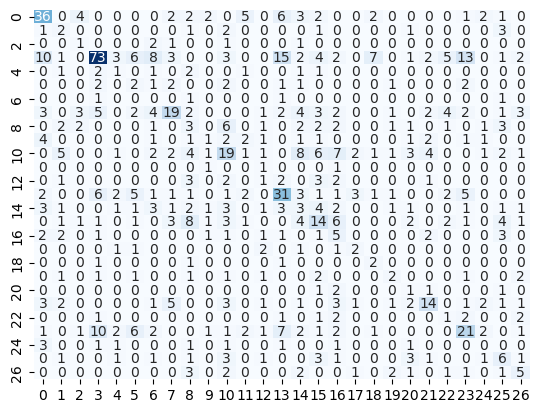

In [39]:
import sklearn
resnet34.eval()
with torch.no_grad():
    for validation_item in validation_loader:
        preds = resnet34(validation_item[0].to(device))
        loss = loss_fn(preds, validation_item[1].to(device))
        cf_mat = sklearn.metrics.confusion_matrix(preds.argmax(dim=1).cpu(), validation_item[1].cpu())
        sns.heatmap(cf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.show()
        

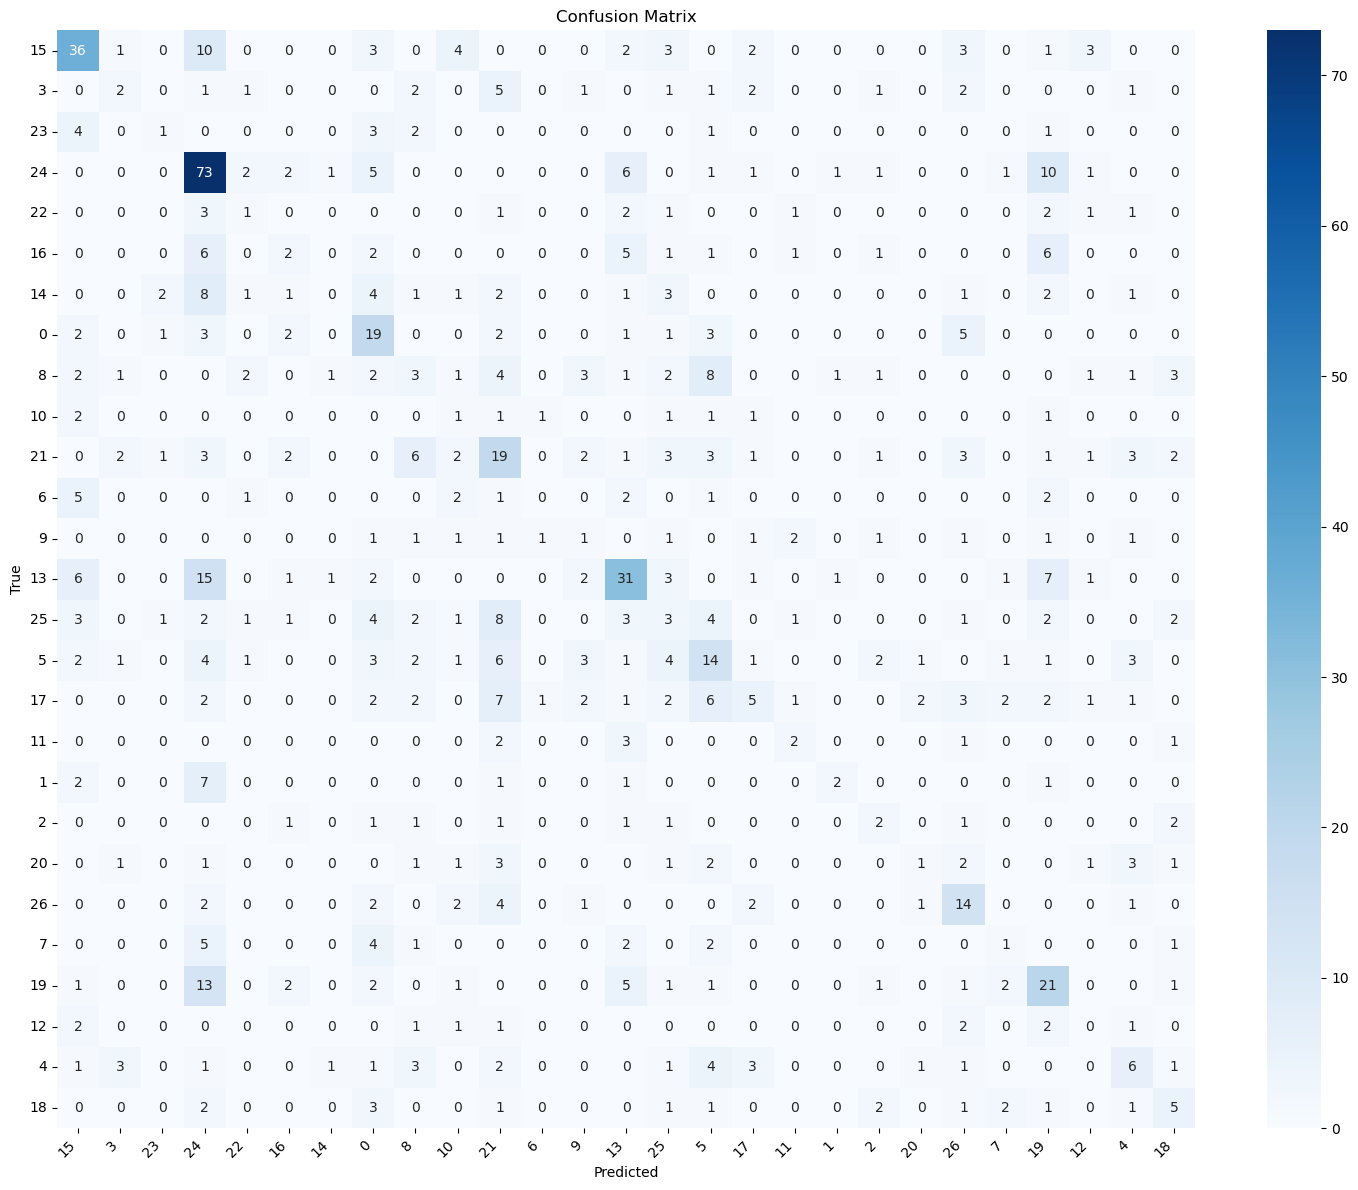


Classification Report:


TypeError: object of type 'numpy.int64' has no len()

In [42]:
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, validation_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 전체 데이터에 대한 confusion matrix 계산
    cf_matrix = sklearn.metrics.confusion_matrix(all_labels, all_preds)
    
    # 시각화
    plt.figure(figsize=(15, 12))
    sns.heatmap(cf_matrix, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 정확도, 정밀도, 재현율 등의 메트릭 출력
    print("\nClassification Report:")
    print(sklearn.metrics.classification_report(all_labels, all_preds, 
                                             target_names=class_names))

# 클래스 이름 가져오기
class_names = train_df['genus'].unique()

# 혼동 행렬 플로팅
plot_confusion_matrix(resnet34, validation_loader, device, class_names)

In [51]:
# load model torch version
model = resnet34
model_path = "./checkpoints/pre-trained_241126-093510_total_aug.pth!!"
best_model_weight = torch.load(model_path, weights_only=True)
model.load_state_dict(best_model_weight)
model.to(device)
model.eval()
with torch.no_grad():   
    for validation_item in validation_loader:
        print(validation_item[0].shape, validation_item[1].shape)
        preds = model(validation_item[0].to(device))
        loss = loss_fn(preds, validation_item[1].to(device))
        outputs_idx = torch.argmax(preds, dim=1)
        corrects = (outputs_idx == validation_item[1].to(device)).sum().item()

        val_acc = corrects / len(validation_loader.dataset) 
        print(val_acc)
        break


torch.Size([852, 3, 64, 64]) torch.Size([852])
0.12910798122065728


In [ ]:
submission_df = pd.read_csv(args['submission_path'])
submission_df.head()